# Task 1:

In [1]:
import warnings
warnings.filterwarnings("ignore")
!pip install yfinance
import pandas as pd
import io
import yfinance as yf
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import acf
import matplotlib.pylab as plt
from google.colab import files
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# select anthof04.csv
data_to_load = files.upload()

Saving anthof04.csv to anthof04 (1).csv


In [3]:
df = data = pd.read_csv(io.BytesIO(data_to_load['anthof04.csv']), sep = ',')
df = df.rename(columns = {"Unnamed: 0":"ID"})
df.head()

,ID,symbol,industry,sector,price,beta,logMktCap,peRatioTTM,debtRatioTTM,priceToBookRatioTTM,enterpriseValue
0,2307,CRI,Apparel Retail,Consumer Cyclical,81.8400,1.225671,21.862106,12.424472,0.698188,3.988536,4.586946e+09
1,2445,ESOA,Engineering & Construction,Industrials,2.5400,0.697593,17.561117,10.875000,2.274884,1.111677,6.888546e+07
2,1648,HCDI,Real Estate—Development,Real Estate,0.4776,0.543256,15.742138,1.466667,0.612725,0.078875,6.492564e+07
3,1926,RLX,Tobacco,Consumer Defensive,2.4800,0.411623,22.068417,10.804347,0.083696,1.383882,2.232922e+10
4,2585,SONY,Consumer Electronics,Technology,89.3400,0.898823,25.426535,15.423276,0.778481,1.752745,1.316522e+13


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   1000 non-null   int64  
 1   symbol               1000 non-null   object 
 2   industry             1000 non-null   object 
 3   sector               1000 non-null   object 
 4   price                1000 non-null   float64
 5   beta                 1000 non-null   float64
 6   logMktCap            1000 non-null   float64
 7   peRatioTTM           1000 non-null   float64
 8   debtRatioTTM         1000 non-null   float64
 9   priceToBookRatioTTM  1000 non-null   float64
 10  enterpriseValue      1000 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 86.1+ KB


As we have numerical variables and categorical variables as well, I will reduce the data set to a few variables ('beta', 'logMktCap', 'peRatioTTM', 'debtRatioTTM', 'priceToBookRatioTTM') of numerical nature only in order to have a simpler example from the start. I create the dataframe my_df_with_symbols for Exercise 5. This df contains the symbol and enterpriseValue additionally.

In [5]:
my_df = pd.DataFrame()
my_df = df[['beta', 'logMktCap', 'peRatioTTM', 'debtRatioTTM', 'priceToBookRatioTTM']]
my_df_with_symbols = df[['symbol', 'beta', 'logMktCap', 'peRatioTTM', 'debtRatioTTM', 'priceToBookRatioTTM', 'enterpriseValue']]
my_df_with_symbols.head()

,symbol,beta,logMktCap,peRatioTTM,debtRatioTTM,priceToBookRatioTTM,enterpriseValue
0,CRI,1.225671,21.862106,12.424472,0.698188,3.988536,4.586946e+09
1,ESOA,0.697593,17.561117,10.875000,2.274884,1.111677,6.888546e+07
2,HCDI,0.543256,15.742138,1.466667,0.612725,0.078875,6.492564e+07
3,RLX,0.411623,22.068417,10.804347,0.083696,1.383882,2.232922e+10
4,SONY,0.898823,25.426535,15.423276,0.778481,1.752745,1.316522e+13




---



There exist few outliers for the variables peRatioTTM, debtRatioTTM and priceToBookRatioTTM when we look at their pairwise relationships. I will exclude them so that we get more meaningful results in the next Exercises.

This is the pairplot of the original datapoints



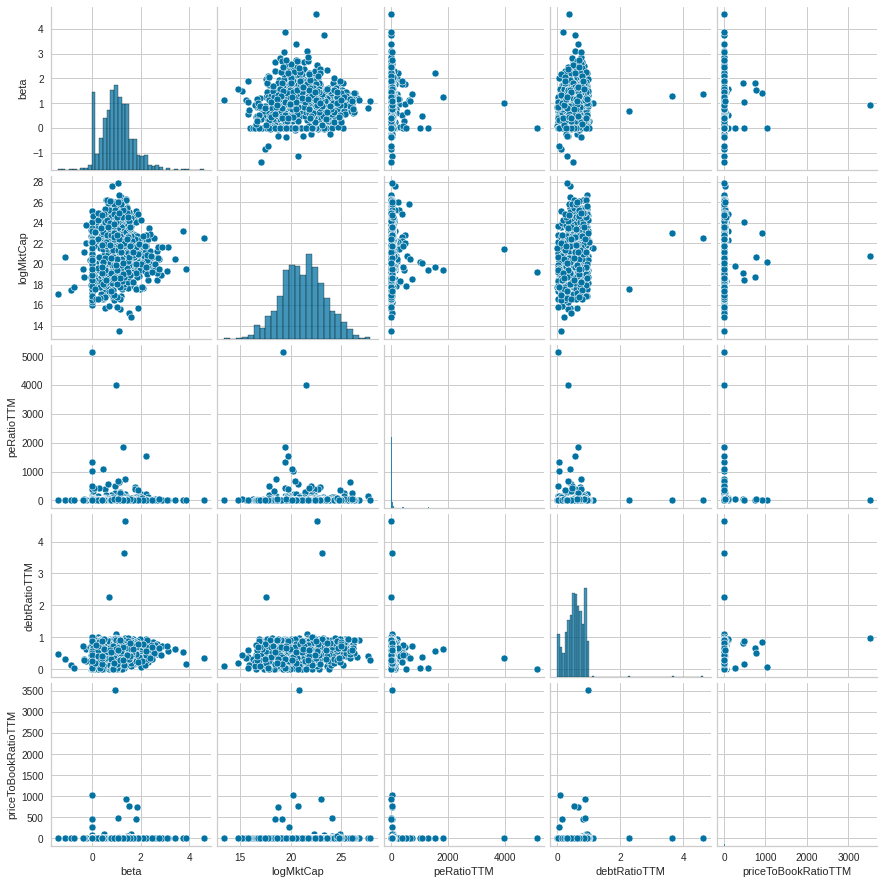

In [6]:
print('This is the pairplot of the original datapoints\n')
sns.pairplot(my_df)

In [7]:
def reduce_outliers(df):
  df = df[df['peRatioTTM'] < 120]
  df = df[df['debtRatioTTM'] < 2]
  df = df[df['priceToBookRatioTTM'] < 15]
  df.reset_index(inplace=True, drop=True)
  return df

my_df = reduce_outliers(my_df)
my_df_with_symbols = reduce_outliers(my_df_with_symbols)
my_df_with_symbols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   symbol               920 non-null    object 
 1   beta                 920 non-null    float64
 2   logMktCap            920 non-null    float64
 3   peRatioTTM           920 non-null    float64
 4   debtRatioTTM         920 non-null    float64
 5   priceToBookRatioTTM  920 non-null    float64
 6   enterpriseValue      920 non-null    float64
dtypes: float64(6), object(1)
memory usage: 50.4+ KB


This is the pairplot of the modified datapoints which excludes 80 (only 8%) companies of the original dataset



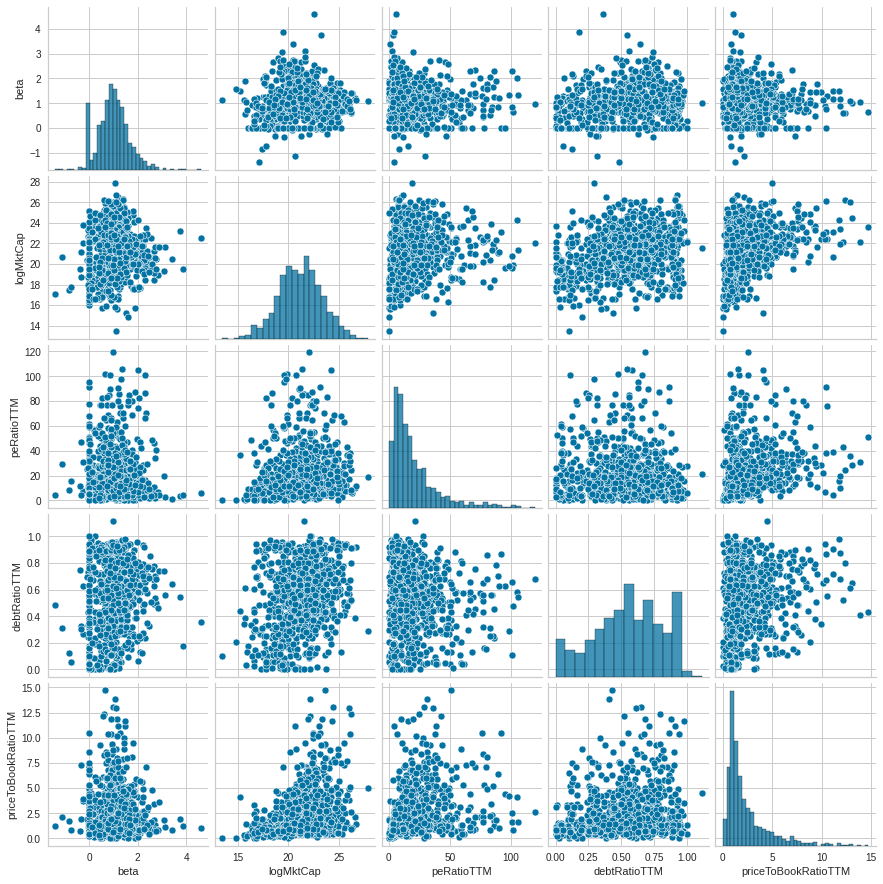

In [8]:
print('This is the pairplot of the modified datapoints which excludes 80 (only 8%) companies of the original dataset\n')
sns.pairplot(my_df)



---


Now, I will cluster the data and try to find the perfect number of clusters by summing up the distances of all points to their cluster centers (inertia) by iterativele trying different ones. With the elbow method we chose the amount of clusters after the inertia starts to decrease in a linear fashion.

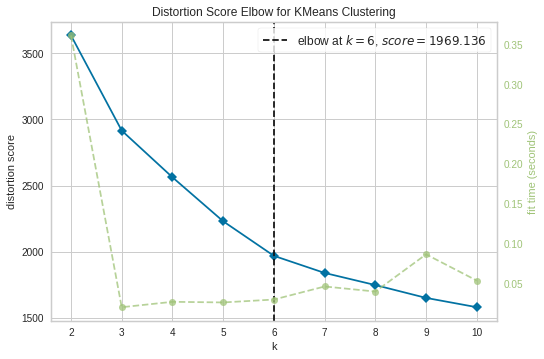

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
warnings.filterwarnings("ignore")
# Now, I standardize the data to apply the kmeans algorithm to the variables
scaler = StandardScaler()
X_data = scaler.fit_transform(my_df)

# Instantiate a KMeans object and a KElbowVisualizer object
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,11), metric='distortion')

# Fit the visualizer to the data and display the plot
visualizer.fit(X_data)
visualizer.show()

**Interpretation**

If the elbow method for k-means clustering suggests that the optimal number of clusters is **6**, it means that partitioning the data into 6 distinct groups based on the variables 'beta', 'logMktCap', 'peRatioTTM', 'debtRatioTTM', and 'priceToBookRatioTTM' would provide the best balance between minimizing the within-cluster sum of squares and maximizing the between-cluster differences. In other words, it's the point where adding more clusters doesn't significantly decrease the distortion score anymore.

Nevertheless, the elbow method has some disadvanteges: the choice of the number of clusters is often subjective and requires some prior knowledge of the data or domain expertise.

# Task 2:

Now I will evaluate the number of clusters with average silhouette scores.

In [10]:
warnings.filterwarnings("ignore")

# define a dictionary that contains all of our relevant info.
results_dict = {}

# define how many clusters we want to test up to.
num_of_clusters = 10

# run through each instance of K
for k in range(2, num_of_clusters):
    
    print("-"*100)
    
    # define the next dictionary to hold all the results of this run.
    results_dict[k] = {}

    # create an instance of the model, and fit the training data to it.
    kmeans = KMeans(n_clusters=k, random_state = 123).fit(X_data)
    
    # define the silhouette score
    sil_score = metrics.silhouette_score(X_data, kmeans.labels_, metric='euclidean')
    
    # store the different metrics
    results_dict[k]['silhouette_score'] = sil_score
    results_dict[k]['model'] = kmeans
    
    # print the results    
    print("Number of Clusters: {}".format(k))
    print('Silhouette Score:', sil_score)

----------------------------------------------------------------------------------------------------
Number of Clusters: 2
Silhouette Score: 0.22686495935663867
----------------------------------------------------------------------------------------------------
Number of Clusters: 3
Silhouette Score: 0.23073961053974468
----------------------------------------------------------------------------------------------------
Number of Clusters: 4
Silhouette Score: 0.24088655722492566
----------------------------------------------------------------------------------------------------
Number of Clusters: 5
Silhouette Score: 0.22064811757009425
----------------------------------------------------------------------------------------------------
Number of Clusters: 6
Silhouette Score: 0.22902895358807882
----------------------------------------------------------------------------------------------------
Number of Clusters: 7
Silhouette Score: 0.21165295043824145
----------------------------------

In [11]:
#define a function which plots silhouette scores for a given k-means clustering model
def plot_silhouettes(data, k_means):
    X = data
    labels = k_means.labels_

    n_clusters = len(np.unique(labels))

    fig, ax = plt.subplots(1, 1, figsize = (8, 6))

    x_split = 10

    ax.set_xlim([0, len(X) + (n_clusters + 1) * x_split])
    ax.set_ylim([np.min(silhouette_samples(X, labels)) - 0.1, 1])

    x_lower = x_split

    sample_silhouette_scores = silhouette_samples(X, labels)

    for i in range(n_clusters):

        ith_cluster_silhouette_scores = sample_silhouette_scores[labels == i]
        ith_cluster_silhouette_scores.sort()

        ith_size = ith_cluster_silhouette_scores.shape[0]

        x_upper = x_lower + ith_size

        ax.fill_between(np.arange(x_lower, x_upper), 0, 
                        ith_cluster_silhouette_scores)

        x_lower = x_upper + x_split

    ax.set_xlabel('Observations')
    ax.set_ylabel('Silhouette score')
    ax.set_title(f'Avg. Silhouette score: {silhouette_score(X, labels):.2f}')
    plt.show()

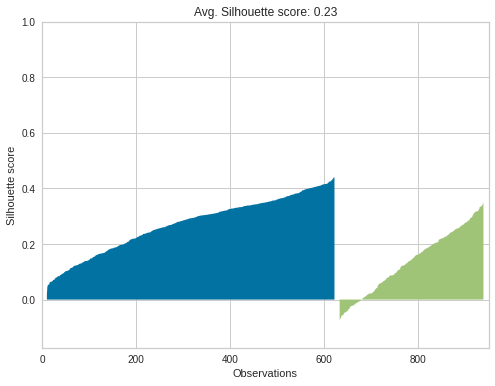

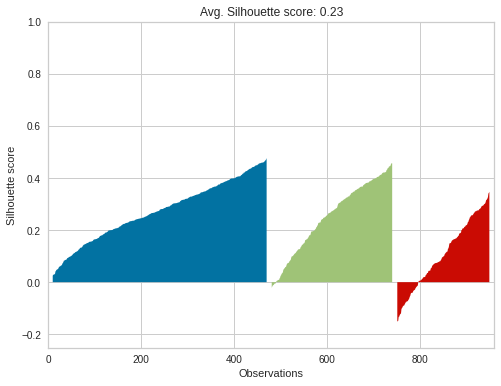

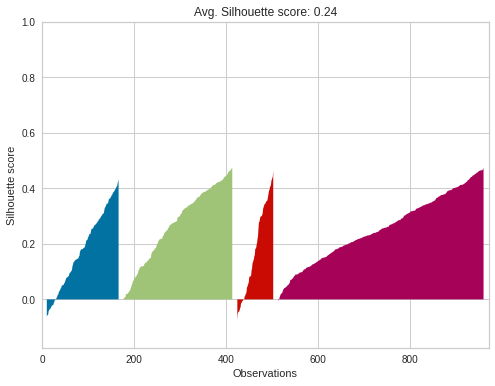

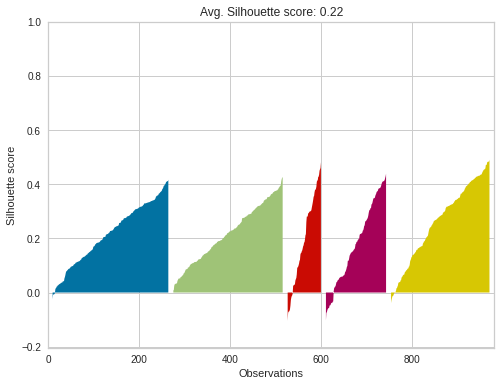

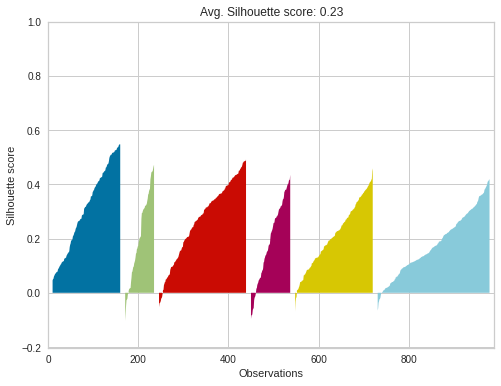

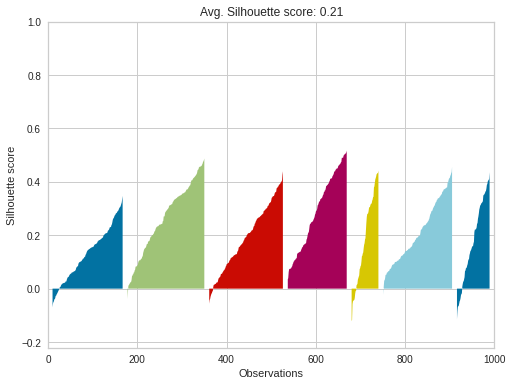

In [12]:
n_clusters = [2, 3, 4, 5, 6, 7]

for n in n_clusters:
    kmeans = KMeans(n, random_state = 123).fit(X_data)
    plot_silhouettes(X_data, kmeans)

**Interpretation**

The highest value of the silhouette score is at **4** clusters, which implies that 4 clusters are the optimal number of clusters for the given dataset, as it produces the best separation of the data points into distinct clusters. This means that each cluster contains data points that are more similar to each other than to data points in other clusters, which is a desirable outcome for clustering. A high silhouette score indicates that the clusters are well-defined and well-separated, while a low silhouette score suggests that the data points are not well-matched to their assigned clusters or that there is too much overlap between the clusters. Range of silhouette score [-1;1].

# Task 3:

In [13]:
# perform k-means clustering with 6 clusters
kmeans = KMeans(n_clusters=6, random_state=123)
kmeans.fit(X_data)

# assign each observation to a cluster
labels = kmeans.predict(X_data)

# count the number of observations in each cluster
counts = np.bincount(labels)

# print the number of companies in each cluster
for i, count in enumerate(counts):
    print(f"Cluster {i}: {count} companies")

Cluster 0: 151 companies
Cluster 1: 65 companies
Cluster 2: 194 companies
Cluster 3: 88 companies
Cluster 4: 173 companies
Cluster 5: 249 companies


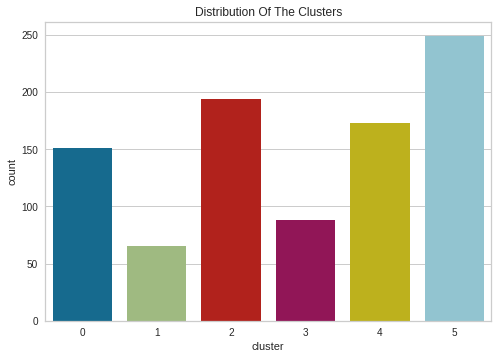

In [14]:
# estimate clusters with a specified cluster number
kmeans = KMeans(n_clusters = 6, random_state = 123).fit(X_data)
# add the cluster label to the data
my_df_with_symbols['cluster'] = kmeans.labels_
my_df['cluster'] = kmeans.labels_

# check out the distribution of cluster members
pl = sns.countplot(x = my_df_with_symbols['cluster'])
pl.set_title('Distribution Of The Clusters')
plt.show()

**Critics on the results:**

K-means clustering is a unsupervised learning technique, meaning that the algorithm does not use any prior knowledge or labeled data to group the observations. Therefore, the generated clusters may not reflect meaningful or real-world differences in the data. 

Furthermore, the results may be very sensitive to the choice of the k value. Also, as we can see in the distribution above, the amount of companies in cluster 1 & 3 is significant lower (65 and 88 companies). They also might contain some outliers which I couldn't sort out in Exercise 1, so that they were put into an "outliers cluster".

Overall, the results of k-means clustering should be interpreted critically, taking into account the number and size of the clusters, the interpretation of the clusters, and the evaluation of the clustering's effectiveness. K-means clustering results presented here may provide some initial insights and suggestions for further analysis, they should be carefully interpreted and validated with additional data and techniques. 

# Task 4:

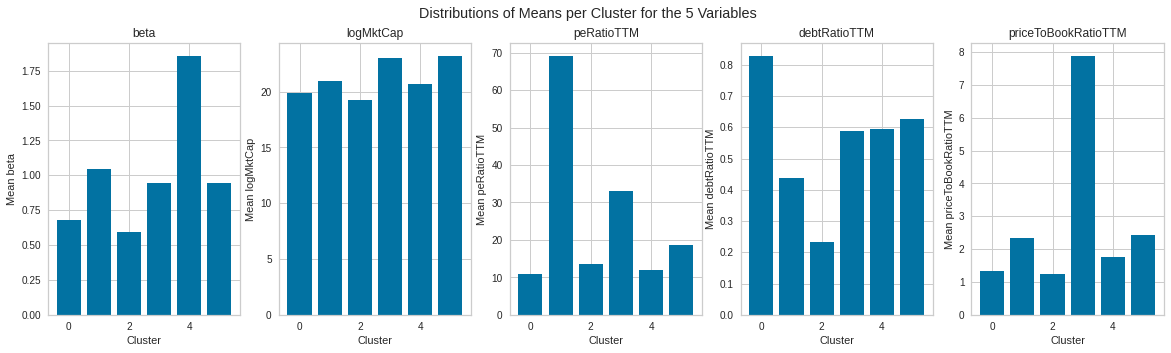

In [15]:
# calculate means per cluster
means_per_cluster = my_df.groupby('cluster')['beta', 'logMktCap', 'peRatioTTM', 'debtRatioTTM', 'priceToBookRatioTTM'].mean()

# create a figure with 5 subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# loop through the 5 variables and plot their distributions for each cluster
for i, var in enumerate(means_per_cluster.columns):
    axs[i].bar(means_per_cluster.index, means_per_cluster[var])
    axs[i].set_title(var)
    axs[i].set_xlabel('Cluster')
    axs[i].set_ylabel('Mean ' + var)

# set the title for the entire plot
fig.suptitle('Distributions of Means per Cluster for the 5 Variables')
plt.show()

In [16]:
means_per_cluster

,beta,logMktCap,peRatioTTM,debtRatioTTM,priceToBookRatioTTM
cluster,,,,,
0,0.677709,19.858000,10.924702,0.828316,1.334719
1,1.042313,20.939706,69.116847,0.438424,2.337244
2,0.593815,19.236811,13.673917,0.233689,1.253684
3,0.947360,23.055484,33.184267,0.588884,7.878896
4,1.855546,20.713532,11.990859,0.595456,1.762985
5,0.946232,23.195173,18.581318,0.626066,2.433733


**Interpretation**

Comparing the distributions above, each cluster has the highest average value for one of the five variables, except cluster 2.




*   Cluster 0 (16% of all companies) has the highest debtRatioTTM and the lowest peRatioTTM, which implies that investors are pessimistic about those highly indebted companies' future growth prospects and won't pay a high price for them
*   Cluster 1 (7% o.a.c.) has the hightest peRatioTTM, which implies that investors are optimistic about those companies future growth prospects and overvalue them
*   Cluster 2 (21% o.a.c.) has the lowest beta, peRatioTTM and priceToBookRatioTTM, which implies that this cluster contain stable value stocks with low growing rates
*   Cluster 3 (10% o.a.c.) has the highest priceToBookRatioTTM, which implies that the companies in this cluster have high market values compared to their book values (similar to the FF3 HML factor)
*   Cluster 4 (19% o.a.c.) has the highest beta, which implies that the companies in this cluster are very sensitive to the market
*   Cluster 5 (27% o.a.c.) has the highest logMktCap, which means that there are large companies in this cluster measured by their market capitalization

In conclusion the variables are very different across the clusters, which indicates that we have similar companies in each cluster that are different from the other companies in the other clusters.

# Task 5:

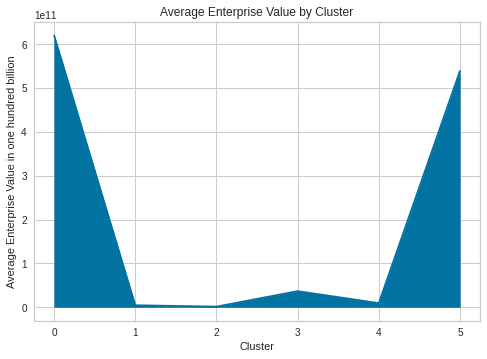

In [17]:
# average enterprise values per cluster
averages = my_df_with_symbols.groupby('cluster')['enterpriseValue'].mean()

# plot the means
averages.plot(kind='area')
plt.xlabel('Cluster')
plt.ylabel('Average Enterprise Value in one hundred billion')
plt.title('Average Enterprise Value by Cluster')
plt.show()

In [18]:
averages

cluster
0    6.202376e+11
1    4.506900e+09
2    1.386354e+09
3    3.676048e+10
4    9.338245e+09
5    5.391455e+11
Name: enterpriseValue, dtype: float64

<AxesSubplot:>

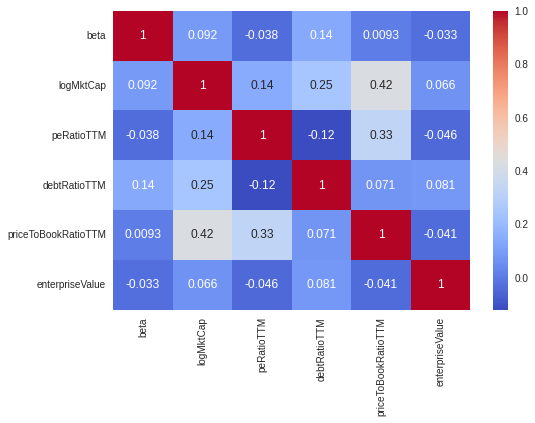

In [19]:
# select columns to consider
columns = ['beta', 'logMktCap', 'peRatioTTM', 'debtRatioTTM', 'priceToBookRatioTTM', 'enterpriseValue']

# calculate correlation matrix
corr_matrix = my_df_with_symbols[columns].corr()

# create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

According to the heatmap, none of the 5 varables have a siginficant correlation with the enterpriseValue. So, lets make a regression to find out, which variables influence the enterpriseValue...

In [20]:
import statsmodels.api as sm
import pandas as pd

# define the dependent variable
y = my_df_with_symbols['enterpriseValue']

# define the independent variables
X = my_df_with_symbols[['beta', 'logMktCap', 'peRatioTTM', 'debtRatioTTM', 'priceToBookRatioTTM']]

# add a constant term to the independent variables
X = sm.add_constant(X)

# fit the multiple linear regression model
model = sm.OLS(y, X).fit()

# print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        enterpriseValue   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.251
Date:                Sun, 12 Mar 2023   Prob (F-statistic):            0.00647
Time:                        09:28:14   Log-Likelihood:                -27943.
No. Observations:                 920   AIC:                         5.590e+04
Df Residuals:                     914   BIC:                         5.593e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -2.949e+12   1

In [21]:
# logarithmical means_per_cluster give a more relative insight of the variables weights
np.log(means_per_cluster)

,beta,logMktCap,peRatioTTM,debtRatioTTM,priceToBookRatioTTM
cluster,,,,,
0,-0.389037,2.988607,2.391026,-0.188361,0.288721
1,0.041443,3.041647,4.235799,-0.824570,0.848973
2,-0.521188,2.956826,2.615490,-1.453765,0.226087
3,-0.054076,3.137904,3.502076,-0.529526,2.064188
4,0.618179,3.030787,2.484145,-0.518428,0.567008
5,-0.055268,3.143944,2.922157,-0.468299,0.889426


**Interpretation**


The average enterprise values of the individual clusters differ significantly. In the linar regression with the dependent variable enterpriseValue, we can see the impact of the other variables on the enterpriseValue (notice: R-squared = 0.017). 

***Interesting facts***

*   Cluster 0 & 5 (45% of all companies) have significantly higher average enterprise values (620 billion and 540 billion) while having the highest average debtRatioTTM's
*   The other clusters may contain smaller or newer companies that are not as valuable as those in cluster 0 & 5

***Interesting facts including the linear regression***

*   The "logMktCap" variable (positive coefficient of 1.587e+11), indicates that companies with higher market capitalizations tend to have higher enterprise values
*   The "debtRatioTTM" variable (positive coefficient 9.977e+11), indicates that companies with higher debt ratios tend to have higher enterprise values
*   Therefore cluster 0 & 5 were those with the highest logMktCap or debtRatioTTM
*   The other variables have no significant (α = 5%) effect on enterprise value




---



---


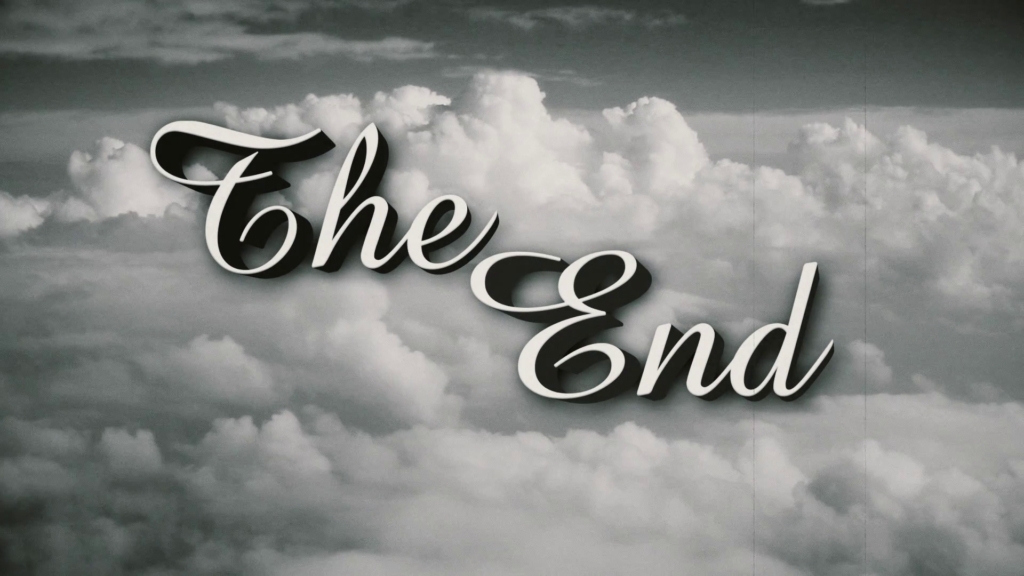